In [ ]:
from google.colab import files


uploaded = files.upload()

Saving melbourne_data_description.txt to melbourne_data_description.txt


In [ ]:
from google.colab import files


uploaded = files.upload()

Saving melbourne_house_data.csv to melbourne_house_data.csv


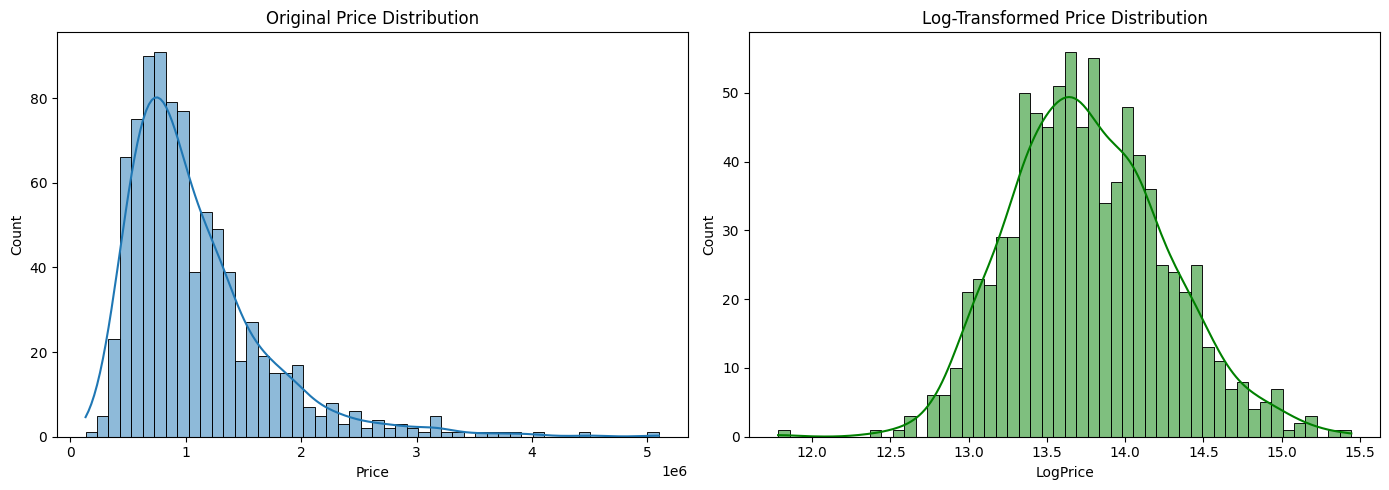

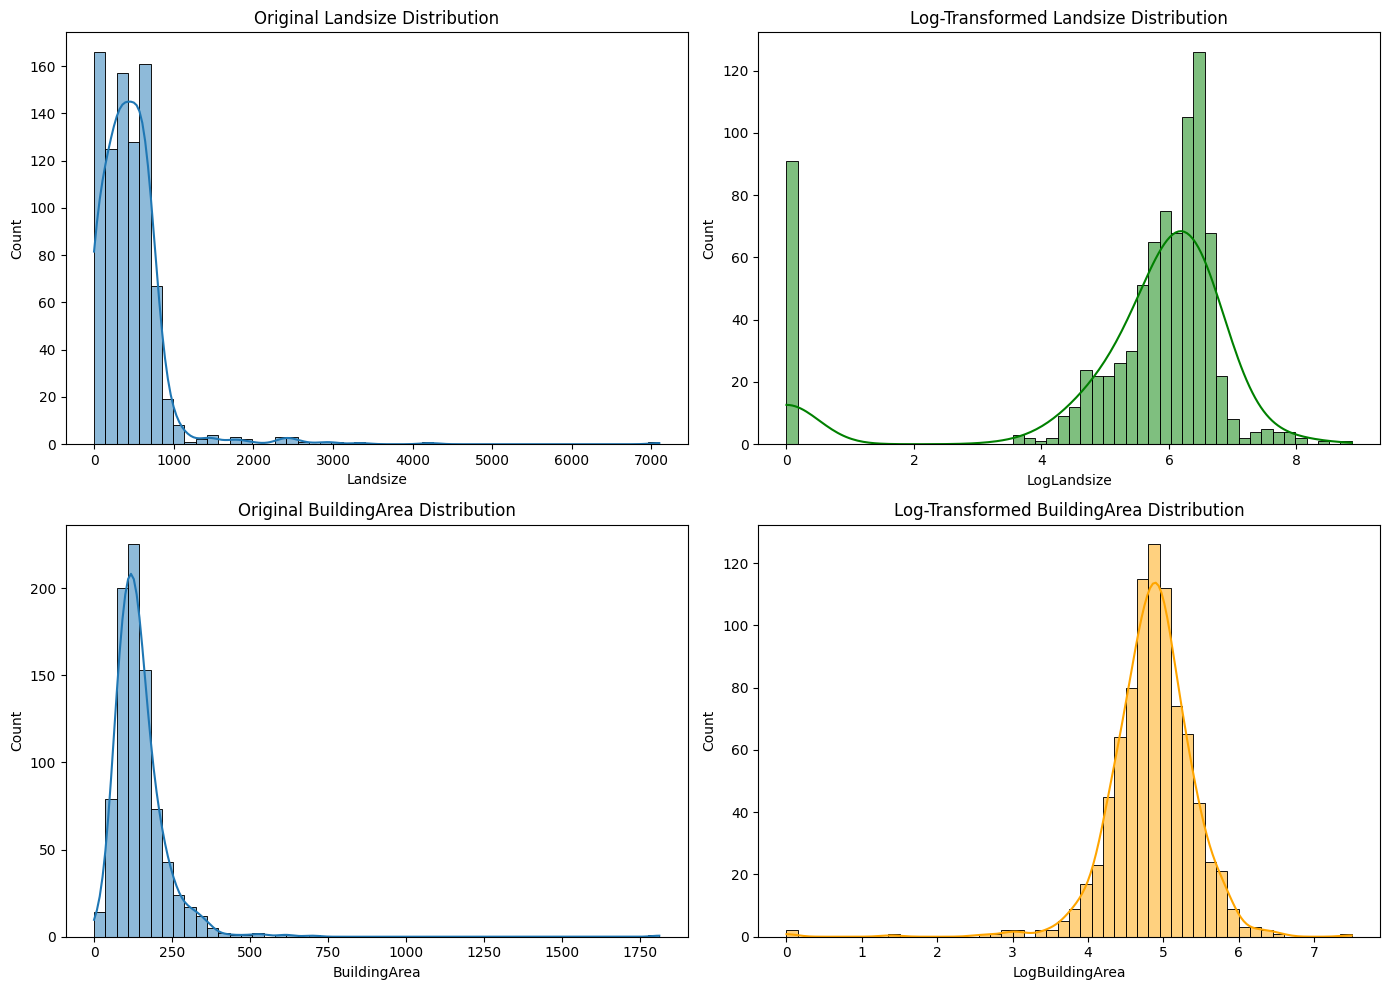

Train R²: 0.828
Train RMSE: 7.708
Test R²: 0.068
Test RMSE: 16.910


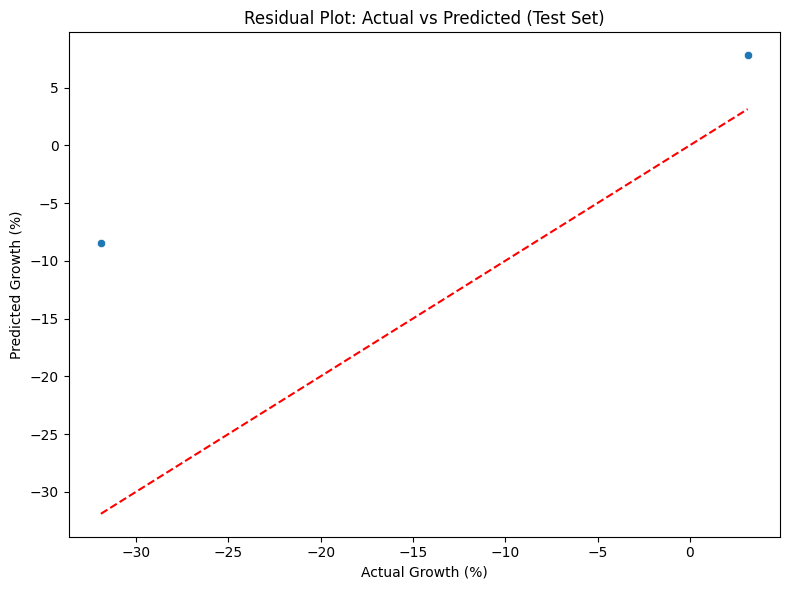

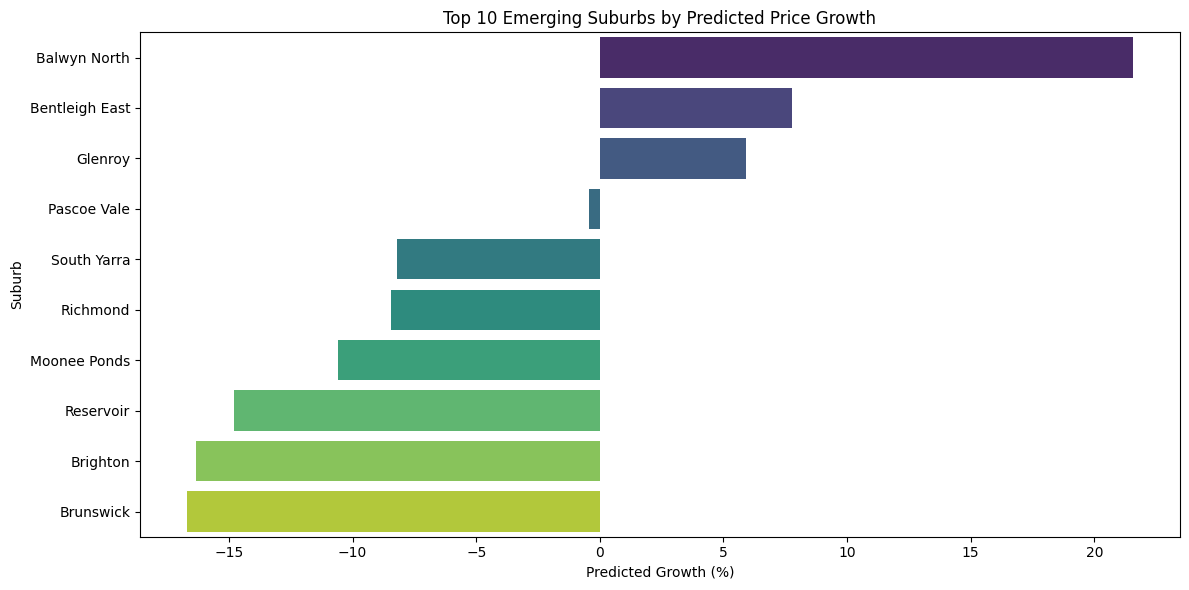

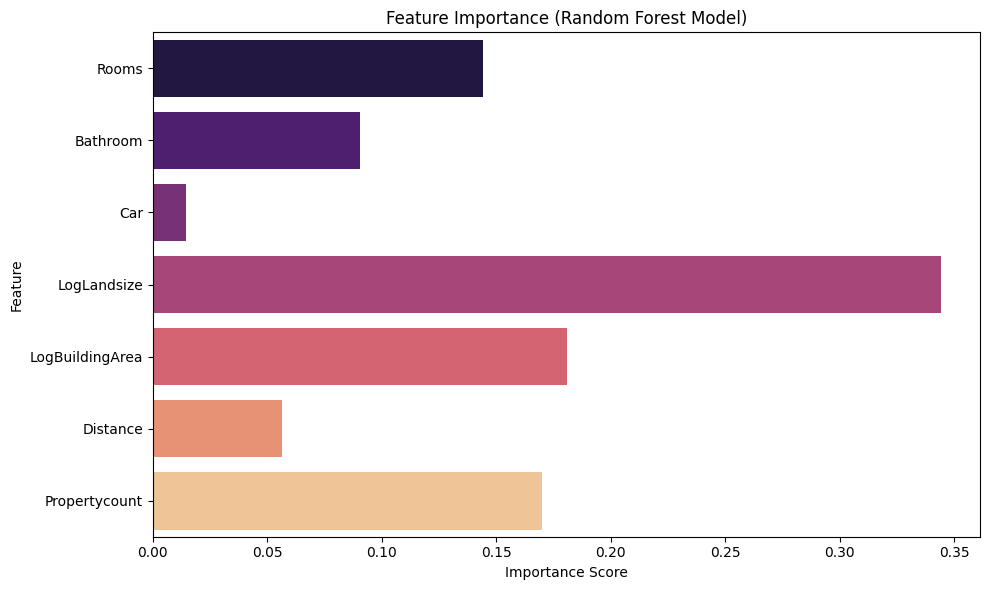

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import warnings

warnings.filterwarnings('ignore')

# Load dataset
df = pd.read_csv('/content/melbourne_house_data.csv')

# Select and clean relevant columns
df = df[['Suburb', 'Date', 'Price', 'Rooms', 'Bathroom', 'Car', 'Landsize', 'BuildingArea', 'Distance', 'Propertycount']]
df = df.dropna(subset=['Suburb', 'Date', 'Price'])
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df = df.dropna(subset=['Date'])

# Aggregate monthly per suburb
df['Month'] = df['Date'].dt.to_period('M').dt.to_timestamp()
monthly_data = df.groupby(['Suburb', 'Month']).agg({
    'Price': 'mean',
    'Rooms': 'mean',
    'Bathroom': 'mean',
    'Car': 'mean',
    'Landsize': 'mean',
    'BuildingArea': 'mean',
    'Distance': 'mean',
    'Propertycount': 'mean'
}).dropna().reset_index()

# Log transformation
monthly_data['LogPrice'] = np.log1p(monthly_data['Price'])
monthly_data['LogLandsize'] = np.log1p(monthly_data['Landsize'])
monthly_data['LogBuildingArea'] = np.log1p(monthly_data['BuildingArea'])

# Histograms before and after log transformation
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
sns.histplot(monthly_data['Price'], bins=50, kde=True)
plt.title('Original Price Distribution')
plt.subplot(1, 2, 2)
sns.histplot(monthly_data['LogPrice'], bins=50, kde=True, color='green')
plt.title('Log-Transformed Price Distribution')
plt.tight_layout()
plt.show()

# Histograms for Landsize and BuildingArea
plt.figure(figsize=(14, 10))
plt.subplot(2, 2, 1)
sns.histplot(monthly_data['Landsize'], bins=50, kde=True)
plt.title('Original Landsize Distribution')
plt.subplot(2, 2, 2)
sns.histplot(monthly_data['LogLandsize'], bins=50, kde=True, color='green')
plt.title('Log-Transformed Landsize Distribution')
plt.subplot(2, 2, 3)
sns.histplot(monthly_data['BuildingArea'], bins=50, kde=True)
plt.title('Original BuildingArea Distribution')
plt.subplot(2, 2, 4)
sns.histplot(monthly_data['LogBuildingArea'], bins=50, kde=True, color='orange')
plt.title('Log-Transformed BuildingArea Distribution')
plt.tight_layout()
plt.show()

# Time series forecasting per suburb
forecast_results = []
forecast_horizon = 6

for suburb in monthly_data['Suburb'].unique():
    df_suburb = monthly_data[monthly_data['Suburb'] == suburb].sort_values('Month')
    if len(df_suburb) < 12:
        continue
    ts = df_suburb.set_index('Month')['LogPrice']
    try:
        model = ExponentialSmoothing(ts, trend='add', seasonal=None)
        fit = model.fit()
        forecast = fit.forecast(forecast_horizon)
        latest_actual = ts.iloc[-1]
        predicted_future = forecast.iloc[-1]
        pct_growth = (np.expm1(predicted_future) - np.expm1(latest_actual)) / np.expm1(latest_actual) * 100
        forecast_results.append({
            'Suburb': suburb,
            'LatestMonth': ts.index[-1],
            'PredictedMonth': forecast.index[-1],
            'ForecastedGrowth(%)': pct_growth
        })
    except Exception:
        continue

# Merge forecast with latest suburb features
growth_df = pd.DataFrame(forecast_results)
latest_features = monthly_data.sort_values('Month').groupby('Suburb').tail(1)
model_data = pd.merge(growth_df, latest_features, on='Suburb')

# Define features and target
features = ['Rooms', 'Bathroom', 'Car', 'LogLandsize', 'LogBuildingArea', 'Distance', 'Propertycount']
target = 'ForecastedGrowth(%)'
X = model_data[features]
y = model_data[target]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train Random Forest
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

# Evaluate model
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"Train R²: {train_r2:.3f}")
print(f"Train RMSE: {train_rmse:.3f}")
print(f"Test R²: {test_r2:.3f}")
print(f"Test RMSE: {test_rmse:.3f}")

# Residual plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_test_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.xlabel("Actual Growth (%)")
plt.ylabel("Predicted Growth (%)")
plt.title("Residual Plot: Actual vs Predicted (Test Set)")
plt.tight_layout()
plt.show()

# Final results
model_data['PredictedGrowth(%)'] = rf.predict(X_scaled)
model_data['GrowthRank'] = model_data['PredictedGrowth(%)'].rank(ascending=False)
final_result = model_data[['Suburb', 'ForecastedGrowth(%)', 'PredictedGrowth(%)', 'GrowthRank'] + features]

# Show top 10 emerging suburbs
top10 = final_result.sort_values(by='PredictedGrowth(%)', ascending=False).head(10)
plt.figure(figsize=(12, 6))
sns.barplot(data=top10, x='PredictedGrowth(%)', y='Suburb', palette='viridis')
plt.title('Top 10 Emerging Suburbs by Predicted Price Growth')
plt.xlabel('Predicted Growth (%)')
plt.ylabel('Suburb')
plt.tight_layout()
plt.show()

# Feature importance plot
importances = rf.feature_importances_
plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=features, palette='magma')
plt.title("Feature Importance (Random Forest Model)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()